In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 42

# Categorical nuisance

In [702]:
from carl.distributions import Mixture, MultivariateNormal

p = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
q0 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([1., 1]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([1., 3.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [703]:
from keras.utils import np_utils

n_samples = 50000
n_samples //= (2 * 3)

X0 = np.vstack([p.rvs(n_samples), 
                q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), 
                q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), 
                q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])

z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2
z = np_utils.to_categorical(z.astype(np.int))

In [704]:
X.shape, y.shape, z.shape

((49998, 2), (49998,), (49998, 3))

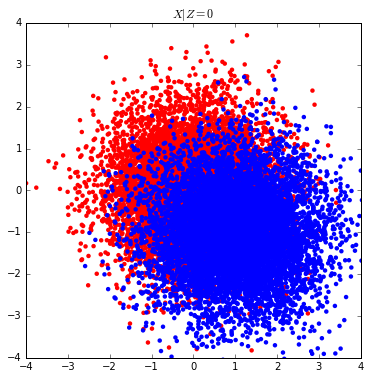

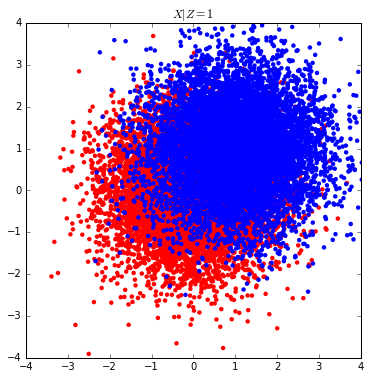

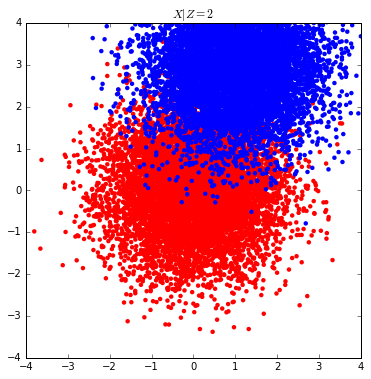

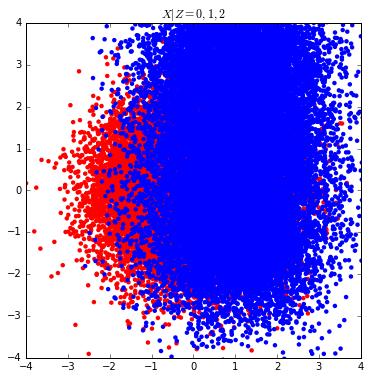

In [705]:
plt.title("$X|Z=0$")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=1$")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=2$")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=0,1,2$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [706]:
from scipy.stats import entropy

# when Z is marginalized out, the best classifier is p.pdf(X) / (p.pdf(X) + q_full.pdf(X)

probas = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
probas = np.hstack([probas.reshape(-1, 1), 
                    (1.-probas).reshape(-1, 1)])
min_Lf = np.mean([entropy(p_i) for p_i in probas])   # lower bound on Lf
min_Lr = entropy([1. / 3] * 3)

In [707]:
min_Lf, min_Lr

(0.47424107260102599, 1.0986122886681096)

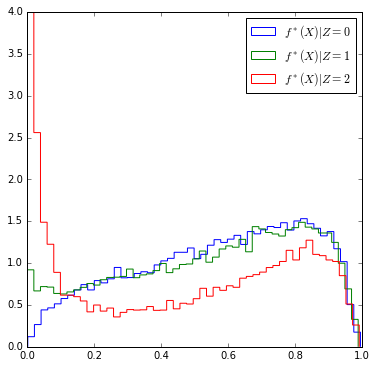

In [708]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0$", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=1$", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=2$", normed=1)
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

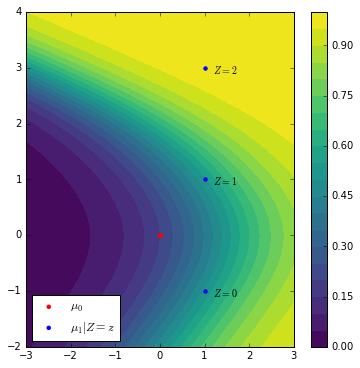

In [726]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [714]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y1, q_full.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.77164896748276024,
 0.80618560875880374,
 0.97216519406006052,
 0.8489879384766974)

# Adversarial training of f

In [715]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [716]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(20, activation="tanh")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [718]:
from keras.optimizers import SGD
import keras.backend as K

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0) 
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [719]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_160 (Model)                (None, 1)             501         input_35[0][0]                   
____________________________________________________________________________________________________
model_161 (Model)                (None, 3)             1024        input_35[0][0]                   
Total params: 1525
____________________________________________________________________________________________________


In [720]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_161 (Model)                (None, 3)             1024        input_35[0][0]                   
Total params: 1024
____________________________________________________________________________________________________


In [723]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 0.5474     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 0.4857     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 0.4794     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 0.4785     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 0.4780     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.4776     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.4771     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.4768     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.4764     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.4760     


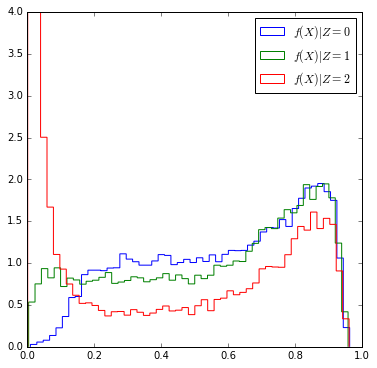

In [724]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

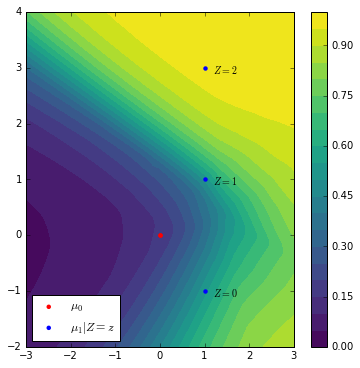

In [727]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [728]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 0s - loss: 1.0735     
Epoch 2/10
44998/44998 [==============================] - 0s - loss: 1.0479     
Epoch 3/10
44998/44998 [==============================] - 0s - loss: 1.0305     
Epoch 4/10
44998/44998 [==============================] - 0s - loss: 1.0172     
Epoch 5/10
44998/44998 [==============================] - 0s - loss: 1.0070     
Epoch 6/10
44998/44998 [==============================] - 0s - loss: 0.9991     
Epoch 7/10
44998/44998 [==============================] - 0s - loss: 0.9935     
Epoch 8/10
44998/44998 [==============================] - 0s - loss: 0.9897     
Epoch 9/10
44998/44998 [==============================] - 0s - loss: 0.9870     
Epoch 10/10
44998/44998 [==============================] - 0s - loss: 0.9851     


In [729]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()   

In [730]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

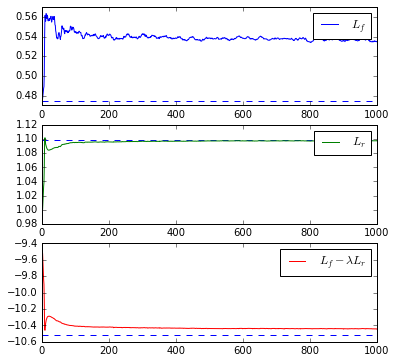

In [731]:
batch_size = 128

for i in range(1001):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

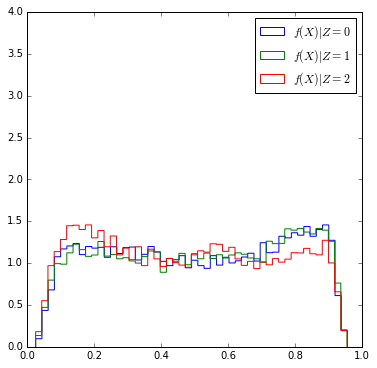

In [732]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

Looks pivotal!

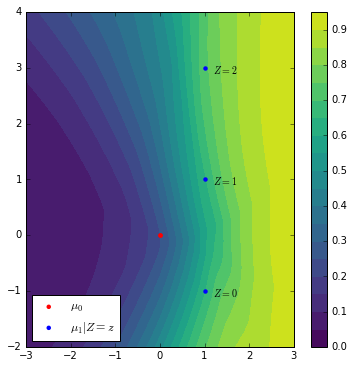

In [733]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, 3-0.1, "$Z=2$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [734]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.78523307738981818,
 0.78204099722851272,
 0.83725350934114162,
 0.80125664964996135)

In [736]:
print(min_Lr)

probas = DfR.predict(X_valid)
mean_entropy_f = np.mean([entropy(q) for q in probas])
print(mean_entropy_f)

1.09861228867
1.0963


---

# Continuous nuisance

In [250]:
np.random.seed = 777
from carl.distributions import Mixture, MultivariateNormal, Uniform

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
p1 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
pz = Uniform(low=0, high=4.0)

In [251]:
n_samples = 50000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]
X1[:, 1] -= 1.0

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

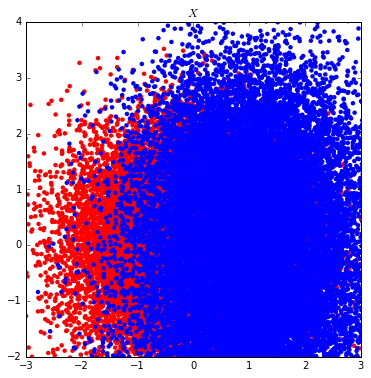

In [252]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.show()

# Adversarial training of f

In [482]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [483]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

# XXX: switch for a mixture density network
# http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.7-MixDensityNetworks.pdf
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(1, activation="tanh")(Rx)  
mu = Lambda(lambda x: (x+1.0)*2)(mu)   
sigma = Dense(1, activation=K.exp)(Rx)
Rx = Merge(mode="concat")([mu, sigma])

R = Model(input=[inputs], output=[Rx])

In [484]:
from keras.optimizers import SGD
import keras.backend as K
import theano.tensor as T

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        a = 0.0
        b = 4.0
        
        z = z_true.ravel()
        mu = z_pred[:, 0].ravel() 
        sigma = z_pred[:, 1].ravel() 
        
        ll = (-K.log(sigma) 
              -np.log(np.sqrt(2. * np.pi)) 
              -((z - mu) ** 2 / (2. * sigma ** 2))
              +np.log(2.)
              -K.log(T.erf((b - mu) / (sigma * np.sqrt(2.))) - 
                     T.erf((a - mu) / (sigma * np.sqrt(2.)))))
        
        return -c * ll.mean()
    
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [485]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_39 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_155 (Model)                (None, 1)             501         input_39[0][0]                   
____________________________________________________________________________________________________
model_156 (Model)                (None, 2)             1003        input_39[0][0]                   
Total params: 1504
____________________________________________________________________________________________________


In [486]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_39 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_156 (Model)                (None, 2)             1003        input_39[0][0]                   
Total params: 1003
____________________________________________________________________________________________________


In [475]:
# # Pretraining of D
# D.trainable = True
# R.trainable = False
# D.fit(X_train, y_train, nb_epoch=10)
# min_Lf = D.evaluate(X_valid, y_valid)

Epoch 1/10
45000/45000 [==============================] - 1s - loss: 0.5928     
Epoch 2/10
45000/45000 [==============================] - 1s - loss: 0.5501     
Epoch 3/10
45000/45000 [==============================] - 1s - loss: 0.5447     
Epoch 4/10
45000/45000 [==============================] - 1s - loss: 0.5437     
Epoch 5/10
45000/45000 [==============================] - 1s - loss: 0.5431     
Epoch 6/10
45000/45000 [==============================] - 1s - loss: 0.5430     
Epoch 7/10
45000/45000 [==============================] - 1s - loss: 0.5429     
Epoch 8/10
45000/45000 [==============================] - 1s - loss: 0.5426     
Epoch 9/10
45000/45000 [==============================] - 1s - loss: 0.5425     
Epoch 10/10
4608/5000 [==========================>...] - ETA: 0s

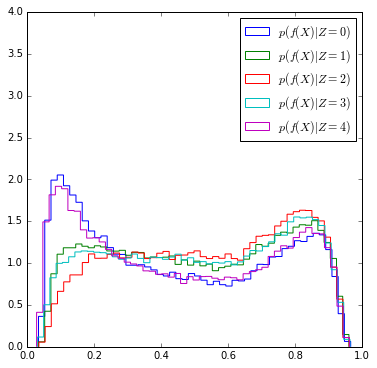

In [476]:
def make_X(n_samples, z):
    X0 = p0.rvs(n_samples // 2)
    X1 = p1.rvs(n_samples // 2)
    X1[:, 1] += z
    X1[:, 1] -= 1.0
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.hist(1. - D.predict(make_X(50000, z=3)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=3)$")
plt.hist(1. - D.predict(make_X(50000, z=4)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=4)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-plain.pdf")
plt.show()

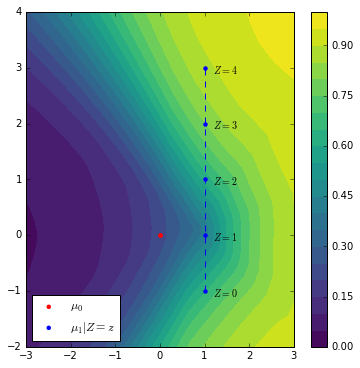

In [477]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0], c="blue", linewidths=0)
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [2], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.vlines(1, -1, 3, color="blue", linestyles="dashed")
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, -1+1-0.1, "$Z=1$", color="k")
plt.text(1.2, -1+2-0.1, "$Z=2$", color="k")
plt.text(1.2, -1+3-0.1, "$Z=3$", color="k")
plt.text(1.2, 3-0.1, "$Z=4$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

In [487]:
from IPython import display

min_Lr = np.log(4.0)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    #plt.savefig("training.pdf")
    
    plt.show()  

In [488]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

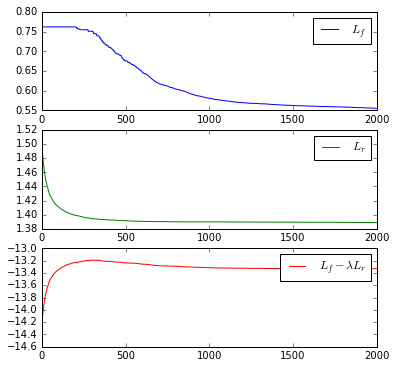

4640/5000 [==========================>...] - ETA: 0s

In [489]:
batch_size = 128

prev_eval = np.inf

for i in range(2001):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit R
    current_eval = DfR.evaluate(X_valid, z_valid)
    diff = np.abs(current_eval - prev_eval)
    
    if diff >= 0.00001:
        prev_eval = current_eval
        print(i, diff)
    
        D.trainable = False
        R.trainable = True

        for j in range(1):
            indices = np.random.permutation(len(X_tradata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYkAAAFrCAYAAAAkUXU0AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xl8VdW9///XhzlhhjAISBBUqlhEFLSKGrVaHKHqVbF1rNZvLdpba2/V/r4X9Odttdfa2wlvtSJapWARp1orag3WqQFkFgIVQQiTYSgBAknI5/vH3gkn4ZxM5+QM4f18PPbjnLOHcxaLk/05a6+9PsvcHRERkWhapboAIiKSvhQkREQkJgUJERGJSUFCRERiUpAQEZGYFCRERCSmNqkuQEOZme7VFRFpAne3ph6bUS0Jd9eSoGXSpEkpL0NLWVSXqs90XuKVUUFCRESSS0FCRERiUpA4TOXl5aW6CC2G6jKxVJ/pxRJxzSoZzMwzpawiIunCzPBUd1yb2VgzW2lmq8zsR1G2dzGzV8xskZktNbMbG3qsiEg8Bg0ahJm1+GXQoEHNUn9xtyTMrBWwCjgP2AjMA65x95UR+9wLdHH3e80sBygE+gCV9R0b8R5qSYhIo4W/pFNdjGYX69+ZDi2J0cBqd1/n7uXADGBcrX0c6Bw+7wxsc/eKBh4rIiIpkogg0R9YH/F6Q7gu0m+A481sI7AY+F4jjhURkRRJ1t1NXwMWuns/4CTgt2bWKUmfLSIiTZSItBxFwMCI1wPCdZFuAn4K4O6fmtlnwJcaeGy1yZMnVz/Py8vTrXIiIrXk5+eTn5+fsPdLRMd1a4KO6POATUABMMHdV0Ts81tgq7vfb2Z9gPnAicC/6js24j3UcS0ijaaO6xR3XLv7AWAiMAdYDsxw9xVmdpuZfTvc7UHgdDNbArwJ/Ie7b491bLxlEhHJJAUFBYwdO5bTTjuNxx9/nO3bt6e6SNU0mE5EWrRMaUmMHz+eq666imuvvbZJxzdXS0JBQkRatEwIEu5Oz549WbZsGf369WvSe6Tt5SYREYnPwoUL6dWrV5MDRHNSkBCRw5pZYpZ4vPPOO5xzzjk11kW2Cnbt2sV9993Ho48+Gt8HNYGChIgc1twTs8QjWpB4+umnq5+//vrrnHvuuXzrW9+K74OaQEFCRCSFKioqeO+992qM+5o5cybHH388AMXFxTz77LPs3LmTzp07x3iX5pMxc1yLiLQ0ixYt4tlnnwXgtddeo6ysjAULFlBQUMDixYsByMnJoX///lx55ZUpKaOChIhIiowYMYIRI0bwyCOP1Llfq1apu+ijy00iImlsz549KbnMVEVBQkQkjS1fvpwxY8ak7PMVJERE0tTMmTP585//zMUXX5yyMmjEtYi0aJkw4joRNOJaRESSTkFCRERiSkiQMLOxZrbSzFaZ2Y+ibL/bzBaa2cdmttTMKsysW7jt+2a2zMyWmNlzZtYuEWUSEZH4JWLSoVbAKoKJgzYC84Br3H1ljP0vAf7d3b9qZv2A94AvuXuZmc0EXnP3Z6Icpz4JEWk09Umkvk9iNLDa3de5ezkwAxhXx/4TgD9GvG4NdDSzNkA2QaAREZE0kIgg0R9YH/F6Q7juEGaWBYwFXgBw943Az4HPCea23unubyWgTCIikgDJTstxKfCeu+8ECPslxgG5BPNdzzKza919epLLJSItVG5uLhZvLu8MkJub2yzvm4ggUQQMjHg9IFwXzTXUvNT0VWCNu28HMLPZwOlA1CAxefLk6ud5eXk1siaKiESzdu3aVBchqfLz88nPz0/Y+yWi47o1UEjQcb0JKAAmuPuKWvt1BdYAA9y9NFw3GngSGAXsB54C5rn7b6N8jjquRUQaKd6O67hbEu5+wMwmAnMI+jiedPcVZnZbsNkfD3cdD7xRFSDCYwvMbBawECgPHx9HRETSgtJyiIi0YOlwC6yIiLRQChIiIhKTgoSIiMSkICEiIjEpSIiISEwKEiIiEpOChIiIxKQgISIiMSlIiIhITAoSIiISk4KEiIjEpCAhIiIxKUiIiEhMCQkSZjbWzFaa2Soz+1GU7Xeb2UIz+9jMlppZRTgrHWbW1cz+ZGYrzGy5mZ2aiDKJiEj8EjHpUCtgFcGkQxuBecA17r4yxv6XAP/u7l8NX08D5rr7U2bWBsh2911RjlOqcBGRRkr5pEPAaGC1u68LCzSDYN7qqEECmEA4hamZdQHOdPcbAdy9AjgkQFQ5DKapFRFJK4kIEv2B9RGvNxAEjkOYWRYwFvhuuOoooNjMngJOBOYD34ucvS6SGhIiIo0T74/rZHdcXwq85+47w9dtgJHAb919JLAXuCfJZRIRkRgS0ZIoAgZGvB4QrovmGsJLTaENwHp3nx++ngUc0vFdZfLkydXP8/LyyMvLa3xpRURasPz8fPLz8xP2fonouG4NFBJ0XG8CCoAJ7r6i1n5dgTXAgMjLSWY2F7jV3VeZ2SSCjutod0ip41pEpJFS3nHt7gfMbCIwh+Dy1ZPuvsLMbgs2++PhruOBN6L0N9wJPGdmbQmCyE3xlklERBIj7pZEsqglISLSePG2JDTiWkREYlKQEBGRmBQkREQkJgUJERGJSUFCRERiUpAQEZGYFCRERCQmBQkREYlJQUJERGJSkBARkZgUJEREJCYFCRERiUlBQkREYkpIkDCzsWa20sxWmVm0uSDuNrOFZvaxmS01swoz6xaxvVW47ZVElEdERBIjEZMOtQJWEUw6tBGYB1zj7itj7H8J8O/u/tWIdd8HTga6uPtlMY5TqnARkUZKh1Tho4HV7r7O3cuBGcC4OvafQMQUpmY2ALgI+H0CyiIiIgmUiCDRH1gf8XpDuO4QZpYFjAVeiFj9C+CHgJoJIiJpJtkd15cC77n7TgAzuxjY4u6LAAsXERFJE3HPcQ0UAQMjXg8I10VzDRGXmoAzgMvM7CIgC+hsZs+4+/XRDp48eXL187y8PPLy8ppeahGRFig/P5/8/PyEvV8iOq5bA4UEHdebgAJggruvqLVfV2ANMMDdS6O8z9nAD9RxLSKSOPF2XMfdknD3A2Y2EZhDcPnqSXdfYWa3BZv98XDX8cAb0QKEiIikp7hbEsmiloSISOOlwy2wIiLSQilIiIhITAoSIiISk4KEiIjEpCAhIiIxKUiIiEhMChIiIhKTgoSIiMSkICEiIjEpSIiISEwKEiIiEpOChIiIxKQgISIiMSUkSJjZWDNbaWarzOxHUbbfbWYLzexjM1tqZhVm1s3MBpjZ38xsebj+zkSUR+qXyElJDneqy8RSfaaXuIOEmbUCfgN8DRgGTDCzL0Xu4+6PuPtJ7j4SuBfID6cwrQDucvdhwFeA79Y+VpqH/hATR3WZWKrP9JKIlsRoYLW7r3P3cmAGMK6O/ScQTmHq7pvD+a1x993ACqB/AsokIiIJkIgg0R9YH/F6AzFO9GaWBYwFXoiybRAwAvhHAsokIiIJkIg5rq8Avubu3w5ffxMY7e6H9C+Y2VXAN9x9XK31nYB84P9395djfI6mpRMRaYKUznENFAEDI14PCNdFcw3hpaYqZtYGmAX8IVaAgPj+kSIi0jSJaEm0BgqB84BNQAEwwd1X1NqvK7AGGODupRHrnwGK3f2uuAoiIiIJF3efhLsfACYCc4DlwAx3X2Fmt5nZtyN2HQ+8UStAnAF8Azg34hbZsfGWSUREEiPuloSIiLRcaT/iur6BelI/M1trZovD1lpBuK67mc0xs0IzeyO8HChRmNmTZrbFzJZErItZf2Z2r5mtNrMVZnZBakqdvmLU5yQz2xBeTahxRUH1GVusAcmJ/H6mdZBoyEA9aZBKIC8c0Dg6XHcP8Ja7DwX+RjDIUaJ7iuA7GClq/ZnZ8cBVwHHAhcAUM9NNFzVFq0+AR919ZLj8FcDMjkP1WZdYA5IT9v1M6yBB4wfqSXTGof/X44Cnw+dPE/QZSRTu/h6wo9bqWPV3GUG/XIW7rwVWE3yPJRSjPiH4ntY2DtVnTDEGJA8ggd/PdA8SDR6oJ3Vy4E0zm2dmt4Tr+rj7Fgi+aEDvlJUuM/WOUX+1v7NF6DvbUBPNbJGZ/T7i8ojqs4EiBiR/ROy/70bXZ7oHCUmMM8K8WRcRNEfPJAgckXQHQ3xUf/GZAgx29xHAZuDnKS5PRgkHJM8Cvhe2KBL2953uQaIxA/UkBnffFD5+AbxE0LzcYmZ9AMysL7A1dSXMSLHqrwg4MmI/fWcbwN2/8IO3Wj7BwUsgqs96xBiQnLDvZ7oHiXnA0WaWa2btCEZsv5LiMmUUM8sOf2VgZh2BC4ClBPV4Y7jbDUDM0e4CBNfLI6+Zx6q/V4BrzKydmR0FHE0wwFRqqlGf4YmsyuXAsvC56rN+U4FP3P2XEesS9v1MRFqOZuPuB8ysaqBeK+DJ2iO5pV59gBfD3FdtgOfcfY6ZzQeeN7ObgXUEdzxIFGY2HcgDeprZ58Ak4CHgT7Xrz90/MbPngU+AcuD2iF/IQsz6PMfMRhDcibcWuA1Un/WJGJC81MwWElxWug94mCh/302pTw2mExGRmNL9cpOIiKRQoqYvPWQEZa3tZ5vZzojRlP9fuF7Tl4qIpLGEXG4yszHAbuAZdx8eZfvZwA/c/bJa6/sCfd19Udi5ugAY5+4r4y6UiIjELSEtiTpGUEY6ZDSlpi8VEUlvyeyT+Eo4mvK1MH9IDabpS0VE0k6yboFdAAx0971mdiHBgK5jqzZGGS0oIiJpIClBIvLE7+6vm9kUM+vh7ttjjBY8hGmOaxGRJoln+udEXm6qPSL14IZweHj4fDRBh/n2cFW00YJRubuWBC2TJk1KeRlayqK6VH2m8xKvhLQkYoygbAe4uz8OXGlm3yEY4VcKXB0eF3W0oIe55EVEJLUSEiTc/dp6tv8W+G2U9e8DrRNRBhERSbyMGnG9qWRTqovQYuTl5aW6CC2G6jKxVJ/pJWNyN5mZz1w2k6uGKQ+diEhDmRmeJh3Xze7dde+muggikoEGDRqEmbXoZdCgQc1Sd2mdKry2v3/+91QXQUQy0Lp16xJyp086M2tyY6FOGdWS+GzHZ+worS/7h4iIJEpKs8CG28aa2UozW2VmP6rrc0464iTmb5yfiCKLiEgDJKol8RTwtXr2edfdR4bLgwBm1gr4TXjsMGCCmX0p1huM6jeKeRvnJajIIiJSn5RmgSWY7Hy1u69z93JgBjAu1huc0u8UtSRERJIo1Vlg+wPrI/bZQB2pwtWSEJGWqqCggLFjx3Laaafx+OOPs3379voPSoK0yALbUIO7D2ZP2R42795M3059E15IEZFUGT16NB06dODOO+/k2mvrTGKRVCnNAgsUAQMjdh0Qrovq/vvvp/vi7ty14S6+fcW3NTJTRFoMd+fdd99lypQpcb1Pfn4++fn5iSkUCRxxHU4a9Kq7fznKtj7uviV8Php43t0HmVlroBA4D9gEFAAT3H1FlPdwd+fHb/+YNq3acP859yek3CLS8oWjjlNdjDp9/PHHTJgwgcLCwiYdH+vfGO+I65RmgXX3A2Y2EZhD0D/yZLQAEWlU/1E8vuDxRBRbRCRtvPPOO5xzzjk11rl7sw2Sa6iMyt3k7hTvLeboXx3N5rs306FNh1QXS0QyQH0tCbs/MSdin9T08+kll1zCddddx9VXX129btq0adx4440NOr65WhIZFyQAznrqLO4Zcw8XHXNRikslIpkg3S83VVRUkJOTQ2FhIX36BHO0zZw5k6OOOorS0lKmTp3KmDFj2L9/PxMnToz6Hml9uSnZxg0dx8srX1aQEJGMt2jRIp599lkAXnvtNcrKyliwYAEFBQUsXryYkpISpk+fzq233pqS8mVkS2L1ttWcNe0siu4qopVlVPopEUmBdG9J1GX79u08+uijPPjgg3Xu11wtiYw8wx7T8xi6d+jOvCINrBORlm3BggWHdGgnU0a2JAAemPsA8zbO46WrX6J1K82AKiKxZXJLoqHSuiVRXxbYiP1GmVm5mV0ese77ZrbMzJaY2XNm1q4hn3nPmHso2V/CfW/fF2/xRUQkhqRlgQ0zvj4EvBGxrh9wBzDS3YcTdKRf05APbNe6HS9c9QKzVsxi9orZTS64iIjElswssHcAs4Cttda3BjqaWRsgG9jY0M/tmd2T5y5/jttfu53Nuzc3psgiItIASem4DlsM4939MSJShrv7RuDnwOcEOZt2uvtbjXnv0wacxi0jb+H6F69nf8X+RBZbROSwl6y7m/4HiJx1zgDMrBvB/BG5QD+gk5k1Ov3hpLMn0a1DNy6efjEl+0sSUV4RESF5g+lOAWZYkIQkB7jQzMoJ8jutcfftAGY2GzgdmB7tTSZPnlz9PC8vrzoLbNvWbfnjFX/klldv4ZsvfpOXrn4p5flORERSISOzwNba76lwv9lhRtgngVHAfoIO8Hnu/tsox3l9ZS07UMZXnvwKt518G98++dtN+4eISIujW2DTPwtspOp/hbsXmNksYCFBhtiFQJNTvLZr3Y7nLn+OM586kxN6n8DpR57e1LcSkRYkNze3xV9dyM3NbZb3zdjBdHV5459vcN2L1zF13FQuOfaSZi6ZiEj6OiyzwDZEQVEBl/7xUp79+rOcP+T8ZiyZiEj6SosR1+lodP/RzPq3WVw7+1rmrp2b6uKIiGSkFtuSqPL66te59dVbGTNwDL+56DfkZOc0Q+lERNKTWhL1uPCYCymcWMgRnY4gb1oem0o2pbpIIiIZo8UHCYCO7Tryi7G/4NovX8sZU89gyZY68xCKiEioxV9uqu25Jc/x72/8O4+c/wjXn3h9i78tTkQOb2lxuSnOVOFdzexPZrbCzJab2amJKFMs3xj+Dd6+/m0e+fARrnj+Cor3Fjfnx4mIZLSUpgoP/RL4i7sfB5wIrEhQmWIa3mc482+dz+Dugxn5u5G8//n7zf2RIiIZKaWpws2sC3Cmuz8Vvk+Fu+9KRJnq075Nex654BGmXDyFy5+/nP9+/7+p9MpkfLSISMZIaapw4Cig2MyeMrOPzexxM8tKRpmqXHLsJcy7dR6zV87m2heupfxAeTI/XkQkrSUrC2ztVOGRnz8S+K67zzez/wHuIcj9dIhYWWDjNbDrQPJvyOeK569gwgsTmH7FdNq1btAsqiIiaSWds8DmEmR3HR5l25qqpwSpwvcA3wb+AXzo7oPD/cYAP3L3S6O8R0LubqrL/or9XPfidawoXsFT457ilH6nNOvniYg0t7S4u6mqLNS8lFTN3QeHy1EE/RK3u/sr7r4FWG9mx4a7ngd8ksAyNUr7Nu2ZeeVM7jnjHi6efjHXvXgdq7etTlVxRERSLlG3wE4HPgCONbPPzewmM7vNzKJN6lC7OXAn8JyZLSK4u+kniShTU5kZ3xj+DVbfsZqjux/N6VNPZ9yMcSzevDiVxRIRSYnDbjBdY+0t38vUhVN5YO4DfHP4N3noqw+pv0JEMoZShSdJ8d5ivvXKt/jXvn8x++rZ9MjqkbKyiIg0VDr1SbRoOdk5zL5qNqP6jeLoXx3Nd1/7rvorRKTFU0uiCdb/az1PfPwEj81/jPMHn8+/Hf9vXDDkAjq265jqoomI1KDLTSm0a/8upi2axqurXmXR5kXcOfpO7jz1Trp26JrqoomIAAoSaaOwuJD/+vt/8ZfVf+HOU+/krq/cRad2nVJdLBE5zKVFn0Q8WWDD9a3CtByvJKI8qTA0ZyjPfP0ZPvzWhxRuK+TYXx/LlHlTKC0vTXXRRESaLCEtiXCk9G7gmWgjrsN9WgFvAqXAVHefHbHt+8DJQBd3vyzG8WndkqhtXtE8Hnj3AeYVzePK46/k0mMv5YIhF2j+ChFJqrRoSTQ1CyyAmQ0ALgJ+n4iypItR/Ufx6oRXmXvjXHK75nLXnLu4/qXr2VO2J9VFExFpsFRngQX4BfBDDh2J3SIMzRnKD8/4IfNunUdra82XH/sy0xZNU7ZZEckIKc0Ca2YXA1vcfZGZ5REj91OV5soCmwzZbbOZNn4ac9fO5f659/Mfb/4Hlx93OWcceQYn9zuZoT2H0rpV61QXU0QyXEvLAnsa8E2gAsgCOgOz3f36KO+RUX0S9flsx2e8uPJFCooKmL9xPlv2bOFrQ77GLSNv4YIhF9DKNM5RROKXNrfAmtkggiDx5Xr2eyrcb3at9WcDP2gpHdeNtW3vNmZ9Mov/XfC/VFRWcMfoOzj3qHMZ0n2IOrtFpMnSIkiEWWDzgJ7AFoJJg9oB7u6P19p3KvBnBYno3J03Pn2Dpxc/zbvr3qVbh27cNOImrhp2FQO7Dkx18UQkw6RFkEiGwyVIRHJ33vv8PaYtmsbLhS8zuPtgrjjuCm4YcQN9O/VNdfFEJAMoSBwmyg+UM3fdXJ5f/jwvrHiBO0ffyWVDL2NY72FKXS4iMSlIHIbW7FjDQ+89xPvr3+ezHZ8xrPcwLj7mYm47+TaO6HxEqosnImlEQeIwt6dsDws3L+S5Jc/xx2V/ZGjOUM7OPZuzcs9izMAxdOvQLdVFFJEUUpCQaqXlpRQUFTB33VzeXfcu/yj6B0f3OJqzc8/mzIFncsbAM9SXIXKYUZCQmMoOlLFg4wLmrpvL3z//Ox+u/5BuHbpx+pGnc+HRF3LRMRfRPat7qospIs0oLYKEmT0JXEIwejpqgr9wv1HAB8DV7j47zNv0DNAHqASecPdfxThWQSJOlV5JYXEhf//87/x51Z95Z+075HbN5diex9K5fWe6tOtCr469GN1/NKcNOE2XqkRagHQJEk3KAmtmfYG+YVqOTsACYJy7r4xyvIJEgpUfKGfJliWs3bmWkrISSvaXsLFkI/8o+gfzNs5jYNeBnD7gdE4bcBrD+wxnWO9hZLfNTnWxRaQR0iJIhAWJmZYj3P49oAwYRZTBdOE+LwG/dve3o2xTkEiiisoKlmxZwofrP+QfRf9gyZYlrNq2iv5d+jO8z3CG9x7Oyf1O5pR+p6ifQySNZUSQCLPAPufu59SRlmMQkA+c4O67o7yHgkSKlR8oZ/X21SzdspTFWxazYNMC5m+cT4c2HTgu5zgGdx/MkO5DGNJjCEO6D2Fw98GaylUkxeINEqnKAlujwOGlplnA96IFCEkPbVu35fhex3N8r+O5+oSrgWBU+Nqda1m1bRWf7viUT7d/ykdFH/Hp9k9Zs2MNHdp0YEiPIZzQ6wTOyj2LEX1HcEzPY3TZSiRDJCtInALMsCBTXQ5woZmVu/srZtaGIED8wd1frutNMjlVeEtlZhzV/SiO6n7UIdvcna17tvLpjk9ZuGkhf/nnX/jZBz9jzY419O7Ym2N7HsvQnkMZ2nNo8DxnKEd2OVIp00XikM6pwgfRhCywZvYMUOzud9VznC43tRAHKg+w7l/rKCwuZNW2VRRuK6RwW/C8aFcRHdp0ILdbLsN6DeOE3ifwpZwvkds1l9xuufTt1Fdp1EUaIS36JJqaBdbMzgDeBZYSzEznwH3u/tcon6EgcRio9Er2lu/lsx2fsWzrMpZtXcaq7atYt3Md6/61jl37dzG8z3BO7HMiR3Y5kv5d+jOgy4DqpUv7Lqn+J4iklbQIEsmgICEAJftLWLh5Icu3LqeopIgNuzbUWFpZKwZ0GUD/Lv3Jyc6hR4ce9MzuSZ+OfejXuR/9u/SnX+d+9O3UlzatknW1VSR1FCREQu7Orv27qgPGttJtbC/dzra929i8ezMbd2+kaFcRG0s2Ury3mJzsHPp17kdOdg452Tn0zOpJz+ye1Y+112W3zdYEUJJxFCREmqCisoItu7dQVFJE8d5itu3dxrbSbWzbuy14XXrw9bbSYJ27k5OdQ6+OveiV3YveHXvTK7tX9eteHWuu69q+q4KKpJyChEiS7C3fS/HeYr7Y8wVf7P2ixuPWPVuD5xHrS8tLycnOCQJHVSAJg0vVuj4d+3Bk1yM5otMRuqtLmoWChEia2l+xv0bQ2Lpna42AsnXPVjbv3syGXRso3ltMv8796NWxF907dKd7VvfgMeJ5j6ygf6V3x9706diH7lnddaeX1EtBQqQF2F+xv/rS147SHezYt4Ptpdurn1c9bivdxpbdW9i6Zyu7y3YHnfNZPchqm0VWmyyy22ZXP2/fpj0dWncIHtt0oFO7TtUBpupyWKd2naqXdq3b6fJYC5QWQaKpWWDDdWMJRmS3Ap5094djHKsgIRKh7EAZW/dsZUfpDkorStlbvpfS8lJKK0opLS9l/4H97K/Yz76Kfeyr2EdJWQlb92ytXnaX7aakrITdZbvZXbabSq+kU7tOdGnfhR5ZPYKWS1bP6seqDvyc7JwaHfzdOnRTiyaNpUuQaGoW2FbAKuA8YCMwD7hGWWBFkq/sQBl7yvbwr/3/Ynvp9uo7w7aXbj/YqV9as5N/W+k2dpftpluHbtUBpXP7zgdbKG071XzdrhOd29V63b4z2W2zq5f2rdurRZNAaZG7yd3fCxP81eUOgvQboyLWjQZWu/s6ADObAYwDDgkSItK82rVuR7usdnTP6s6gboMafFxFZUWNgFLVMqndUvlizxfB8/LdlOwvqbHP3vK91S2hsgNl1QEjq21WjQBSY2lTz/a22dWX4KIturzWMEkZTRRmgR0fZoEdHbGpP7A+4vUGgsAhIhmiTas21XdsJcKBygPVl89qL6Xl0dfvLd/Lpn2bYh5XfXzE9orKijqDSHWQalPP9nqCVKYHo1RlgRURiap1q9bVl6KaU0VlRY2gU2+ACffduW9nsK6iYQHsgB+obrm0a92Otq3aBo+t20Z9XbV0aNOBDm06kNUmq/p57ddZbbPqXR+vVGaBrQCKgIER+w0I10WlLLAikihtWrWhc/vOdG7fuVk/p/xAOaUVwWW08gPlwWNleY3XtddV3XRQWlFafeNBaXnwvGR/SY31+yr21Xi9ddlWdq7cSUVlBeWV5XGXP6VZYM2sNVBI0HG9CSgAJrj7iijHqeNaRKSR0qLjOjILrJl9Th1ZYAkyvQZP3A+Y2URgDgdvgT0kQIiISGpoMJ2ISAsWb0tCI2BERCQmBQkREYlJQUJERGJSkBARkZgUJEREJKaEBAkze9LMtpjZkhjbLzOzxWa20MwKzOyMiG3fN7NlZrbEzJ4zs3aJKJOeDfeXAAAZUklEQVSIiMQvUS2Jp4Cv1bH9LXc/0d1PAr4F/B6qczrdAYwMs8e2Aa5JUJmkDvn5+akuQouhukws1Wd6SUiQcPf3gB11bN8b8bITUBnxujXQ0czaANkEKcOlmekPMXFUl4ml+kwvSeuTMLPxZrYCeBW4GcDdNwI/Bz4nyNm0093fSlaZRESkbkkLEu7+krsfB4wHHgQws24E80fkAv2ATmZ2bbLKJCIidUtkgr9cgsR9Macvjdj3U4LJh84Fvubut4brrwNOdfeJUY5RTg4RkSZIeYK/kIXLoRvMhrj7p+HzkUA7d98eJgM8zcw6APsJssHOi/Ye8fwjRUSkaZKVBfYKM7seKCOY4/oqgo0FZjYLWAiUh4+1s8aKiEiKZEwWWBERSb60H3FtZmPNbKWZrTIzTYHaBGa2NnIwY7iuu5nNMbNCM3vDzLqmupzpKtpg0brqz8zuNbPVZrbCzC5ITanTV4z6nGRmG8zs43AZG7FN9RmDmQ0ws7+Z2XIzW2pmd4brE/b9TOsgYWatgN8QDNQbBkwwsy+ltlQZqRLIc/eT3H10uO4egkGOQ4G/AfemrHTpL9pg0aj1Z2bHE1xOPQ64EJgSTtsrB8UafPuou48Ml78CmNlxqD7rUgHc5e7DgK8A3w3PkQn7fqZ1kABGA6vdfZ27lwMzCG6ZlcYxDv2/Hgc8HT5/muDWZIkixmDRWPV3GTDD3SvcfS2wmuB7LKE6Bt9GO1mNQ/UZk7tvdvdF4fPdwApgAAn8fqZ7kOgPrI94vSFcJ43jwJtmNs/MbgnX9XH3LRB80YDeKStdZuodo/5qf2eL0He2oSaa2SIz+33E5RHVZwOZ2SBgBPARsf++G12f6R4kJDHOcPeRwEUEzdEziZhrPKQ7GOKj+ovPFGCwu48ANhNkYpAGMrNOwCzge2GLImF/3+keJIqAgRGvB4TrpBHcfVP4+AXwEkHzcouZ9QEws77A1tSVMCPFqr8i4MiI/fSdbQB3/yJiEvsnOHgJRPVZjzDv3SzgD+7+crg6Yd/PdA8S84CjzSw3TCF+DfBKisuUUcwsO/yVgZl1BC4AlhLU443hbjcAL0d9A6lSe7BorPp7BbjGzNqZ2VHA0UBBsgqZQWrUZ3giq3I5sCx8rvqs31TgE3f/ZcS6hH0/EzniOuHc/YCZTQTmEAS0J919RYqLlWn6AC+GaU3aAM+5+xwzmw88b2Y3A+sIBzjKoWIMFn0I+FPt+nP3T8zseeATggGit0f8QhZi1uc5ZjaC4E68tcBtoPqsTzg3zzeApWa2kOCy0n3Aw0T5+25KfWownYiIxJTul5tERCSFFCRERCSmuIKEmV1pwfzUB8LsrlXrR4UpIKqWqAO1zOxn4dDwRWb2gpl1iac8IiKSWHH1SZjZUIKOpt8Bd7v7x+H6DkCZu1eGdy0sBo5w98pax38V+Fu430MEWWOVHkJEJE3E1ZJw90J3X02t4fTuvi8iIGRRc07ryP3eitjvI4J7dkVEJE00W5+EmY02s2UErYj/U7sVEcXNwOvNVR4REWm8esdJmNmbBPfaV68iuBf3x+7+aqzj3L0AOCG8JPWMmb3u7mUxPuPHQLm7T6+jHLpXV0SkCZp1+lJ3P7+pbx4eX2hmu4ETgI9rbzezGwlyCp3bgPeKpygSYfLkyUyePDnVxWgRVJeJpfqshzuUlcG+fQeX0tLoz/ftw669Nq6PS/Qc18GTIBvh+nDEdC4wlGAUZc0DgolFfgic5e77E1gWEZHmUVkZnID37q25lJYeui5yKSuD8vLoj9HW1XXyb9MGOnSArKzgsa7ncYorSIS3tv4ayAH+bGaL3P1CYAxwj5mVEXRaf8fdt4fHPAE8Ft4J9WuCubDfDOe9+Mjdb4+nTCJymHKPfvJu6Im8vpN81fZ9+4KTb3Z2cDLOzo69VG3PyoLOnaFdO2jbtu7HqudVJ/rIE37V0rp1w+tlxoy4qjVj0nKYmVK2JFB+fj55eXmpLkaLoLpsoIoK2L07WEpKDj7fvRv27Kk+EecvXUreEUc0/kS+bx+0bx/9JF3fSbwx2zt0gFaZMw7ZzOLqk1CQEJGGqaiA7dth27aaS3Hxwec7dtQMAJHPy8qgU6fgF3WnTjWXjh0bfwKvvU9WVkadvJNFQUJEGsYddu2CrVvhiy+CE3jtX/S7dwf7bNt2MCBUPZaUQLdukJMDPXseXCJfd+8OXbpUn/wHXXwx6zZsSPW//LCQm5vL2rVrD1mvICHS0lVWBifuHTuCk/WWLcGJfsuWYNmx4+BlmNLSmh2c+/cffL57d3Ctu08f6NULunY99Bd91S/9nj2hR4+aj926NfqXeniCaqaKkUix6lpBQiTTRP6i37IF1q+Hzz8PluLi4KS/Y0fwC37HjmDf7OzgZN2jR3CS79MHevcOHrt3P7STNLKTs3374LHqkk4SKUgkj4KEgoSkK3f417+CSziRS9Vlndqvi4uDO1h69QpO8kceCQMHBo+9ewcn/cilW7fglscMpCCRPGkZJMzsSmAycBwwKiLB3yjg8Yhd73f3l+p4nx8A/w3kVN0qG2UfBQlJjr176+6crX3yLy4Ofq336hWc5Hv1qrlEW5eVlep/ZVIoSCRPcwWJeH+eLAW+TpAFtvb6kyOzwJrZK9HyN5nZAOB8gin2RJrH3r2wcSMUFdV83LgxONFHBoTKykM7ZKuW3Fw45ZSaJ/+cnIQMWhJJR3EFCXcvBLBwJFzE+n0RL2NmgQ39gmDU9SvxlEUOQ+7BdfsNGw4uRUUHH4uLD96ZU1YG/fpB//4HH/v3P3jCjwwI2dlgTf7hJdKiNNuFTjMbDUwFBgLXxWhFXEaQvmOp6Y9SoqmsDE7669YFy5o1sGABfPJJsL5DBxgwoOZyxhlBIOjV62Bnb9euOvFLTAUFBfznf/4nO3fu5Oabb+bKK6+kR48eCf+cX/3qV2zevJmf/OQnKStDY9XbJ9GQLLBm9g7wg6o+iVrHDwWeAc6MzAJrZlnAO8D57l5iZp8Bp7j7thjl8EmTJlW/zsvL0yjXlmLvXli1Klg2bAjux//sM1i2DFasCE7wgwYFl3oGDYKTToLhw4OO3o4dU116qUMm9UmMHz+eq666imvjTIhXF3fnmGOO4YMPPqB3794JLUNVXefn55Ofn1+9/v7770/93U11BYlw+9vADyO3m9kJwFvAXoLAMwAoAka7+9Yo76GO60xXVARLlwbBoLAwWFatCvoEhgyBoUODu3w6dQoCwrBhcPzxQZCQjJQpQcLd6dmzJ8uWLaNfv37N+lmTJk2ic+fO3H333QktQ7p2XNcoS/WTBmSBdfdlQN+IYz4DRrr7jgSWSZKtoiK43//TT4NlzZrgceHCoIVw4olBMBg6FC699GBgaEzCMpEEW7hwIb169Wr2AAFwww03cNlllx0SJJJZhsZIdRbYSE6taVAljVVUwMqVMH9+0EdQWBgEgw0boG/foGUweHDwePXV8MADQatA/QKSht555x3OOeecGuvcnaq+0l27dvHQQw+Rk5PDXXfdVb3Pz372M/bt2xf1uBtuuIHc3NxDPqu4uJjS0lLmzZvHqFGjGlyGVNFgOqnfF18El4mWLAkely4NOo6r7g46+WQ47rggKAwaFIwZEKGBl5sScRKM89xwySWXcN1113H11VdXr5s2bRo33ngjADNnzqRnz56MGjWKrnFc/nzjjTdYvXo1HTt2pKCggMcee6zBZahPWg6mSyYFiSSpqAiCwQcfwIcfBo87dgQdxV/+crAMHw4nnBAkchOpQyb0SVRUVJCTk0NhYSF9+gT36MycOZOjjjqK0aNHU1xczE033cQNN9zA5ZdfTqsmZpr94x//yKJFi3j44YfZvXs3xx13HP/85z9p3759nWUoLS1l6tSpjBkzhv379zNx4sSo758JfRKSSVavhr/+FT76KLiTqKQkyBFUXBy0Br7yFTjvPPi//xeOPVYpmKVFWrRoEc8++ywAr732GmVlZSxYsICCggIWL14MQE5ODv379+fKK69s8ud89NFHvPXWWzz55JMAdOrUifHjxzNjxgxOPPHEOstQUlLC9OnTufXWW+P81zaNWhKHA/egz+CDD4Ll738PAsLFFwdjCo45JmgVdOkSDCbr3DnVJZYWIhNaEg1x++23M2XKlJR89vbt23n00Ud58MEH69xPLQlpuMrKoN9g7lx4991gyc4OAsLpp8N3vxvcZaTWgUi99uzZQ+cU/nBasGDBIR3ayaSWREuxbRs8+yy8/Ta8914w2vjss+Gss4Jl4MBUl1AOQy2hJVFQUMCWLVu49NJLU12UOqVlx3UissCa2R3A7UAF8Jq73xNjPwWJSNu2wbx5we2n8+dDfj5cckkw9uCss4LbUEVSLNODxMyZM1m+fDmTJ09ucod1sqRrkBhKMA7id8DdEUGiA1AWmQUWOKJ2/iYzywPuAy5y9wozy3H34hifpSABQXD4yU9g6tQgPcXJJwfLeecFrQeRNJLpQSKTpGWfRAKywH4HeMjdK8LjogaIw15xMbz0ErzwArz/PkyYEAxk69On/mNFROLQbO0nMxttZssIWhH/J1oWWOBY4Cwz+8jM3jGzU5qrPBln40aYMQPGj4ejj4Y5c+DGG4P8R7/7nQKEiCRFvS2JhmSBjcbdC4ATqrLAmtnrkVlgIz6/u7ufFvZjPA8MjvWekydPrn7eIrPAugd9Cz/9adDXMGYMXHYZ/OEPui1VRBqkdhbYeKUsC2y4/i/Aw+4+N3z9T+DUaOnCW2SfhHvQMliwIOiE/tOfgkR3d98N3/xmMA+ySAZTn0TypGWfRO2yVD9pQBbY0EvAucBcMzsWaBtrPokW5eOP4amnYPZsKC8/2Pk8bRqcdpqS4IlI2kh1FtingKlmthTYD1wfT3nS3qefwl13BS2H226Dd94JRjsrKIhImtJgumRwD+5Ouu224FLSHXdAVlaqSyXS7HS5KXky4XKT1LZyJfzyl0GA6NEDXn0VTj011aUSSZrc3NyUz4dwuIg2d0UiqCXRHNatg3vvhbfegttvh+uvD+ZaEBFJsnhbEuk9zjzTbNgAEyfCyJFBX8OaNTB5sgKEiGQsBYl4uQeT9Nx+ezAZT1ZWMGvb/fdDp06pLp2ISFzUJ9FUpaXw+OPwi18EKbevvjqYs0H5k0SkBYmrJWFmV5rZMjM7YGYjI9aPMrOFEcv4GMefaGYfhvsUZERajk2bgjuUcnOD0dGzZgW3tv70pwoQItLixHu5aSnwdWBulPUnu/tJwIXA78ws2mf9DJgU7jcJ+O84y9O8Fi6E0aODeaA/+ABefBFOOUXjHESkxUp1FthKoGv4vBtQFE95mk15OfzqV/DQQ/DYYxDHXLciIpmk2fokzGw0MBUYCFwXIwvs94E3zOznBGk9Tm+u8jTJnj3w9NPwP/8T3KH0wQfBXUsiIoeJei83mdmbZrYkYlkaPtY5l5+7F7j7CcAo4D4zi5at7jvA99x9IEHAmNqUf0TCVVTAb38bBIQ5c+CJJ+D11xUgROSwU29Lwt3Pj+cD3L3QzHYDJwC1s8Te4O7fC/ebZWZP1vVeSUkVvnw53HRTcPvqn/8cjHkQEckQ6Zwq/G53XxC+HkTNLLDvA8OrkvxFHLccuN3d55rZeQSz1I2K8RnNP+L6/ffh61+HBx+EW29Vh7SIZLyU5m5KQBbYbwO/NLPWwL7wdWq8/XYwLeizz8IFF6SsGCIi6US5mw4cgP/6L/jf/4Xp06GlzXYnIoc1ZYGNx5YtwQxw5eUwfz7065fqEomIpJXDN3fTq6/CSScFM8G99ZYChIhIFIdfS2L/fvj+9+Gvf4UZM+Css1JdIhGRtHV4BYmtW2HcOOjbFxYtgi5dUl0iEZG0dvhcbtqwAc4+G849F154QQFCRKQBmiULbMT2gWZWYmZ3xTi+u5nNMbNCM3vDzLpG2y8uBw7A1KnBtKE33xzcydTq8ImNIiLxaK4ssFV+DvyljuPvAd5y96HA34B74yxPTRUVcMUV8Pvfw+zZ8MMfJvTtRURaumbJAhuuGwesAfbU8RbjgLPD508D+QSBI37u8J3vBJMD5edDu2ipo0REpC7Nct3FzDoC/wHcT5DdNZbe7r4FwN03A70TUoCKiiCtxtKlQf+DAoSISJPU25IwszeBPpGrAAd+7O6vxjhsMvALd98bNjIaOtov/iHVlZVBeo2SkmD8g+aZFhFpsubKAnsqcIWZ/QzoDhwws1J3n1Jrvy1m1sfdt5hZX2BrXW/aoCywv/kNrF8P776rFoSIHHYyIgtsrW2TgBJ3fzTKtoeB7e7+sJn9COju7lH7JBqUu2nJEjjvPPjoIxgypCn/FBGRFiXe3E3x3gI73szWA6cRZIF9vQHHPBFxu+zDwPlmVgicBzzU5MIsWgRjx8Kvf60AISKSIC0jC+wnnwTZW6dM0fzTIiIR4m1JZH6QKCsLkvR95zvBHU0iIlItpZeb0sIDD0D//nDLLakuiYhIi5PZCf5eegmmTQvmgtBUoyIiCZe5QWLx4uDy0uuvB1ldRUQk4TK3T+Kqq+DMM+GOO1JXKBGRNJfqW2DjzQL7MzNbYWaLzOwFM2tY/u79+2HOnCBQiIhIs0l1Ftg5wDB3HwGspqFZYN95B4YNgz596t9XRESaLKVZYN39rYiXHwFXNOiDX345mGFORESaVaqzwEa6Gah3xDaVlfDKKwoSIiJJkBZZYM3sx0C5u0+vt8RLlgSZXYcOrXdXERGJT6qzwGJmNwIXAefW96aTJ08OxkRkZ5OXnx89C6yIyGGspWWBHUvQuX2Wu2+r5zOCW2BvuQVOPjlIwyEiInVK9S2w8WaB/TXQCXjTzD42s0NaGoeYNw9OOSWeYouISANl1mC6PXugVy/Yvh3at091kURE0t7hleBv0SI4/ngFCBGRJMmsIKFLTSIiSZV5QWLUqFSXQkTksJF5QUItCRGRpMmsjuuuXWHbNmjdOtXFERHJCKm+BTauLLAR+/3AzCrNrEedH3j66QoQIiJJlOossJjZAOB8YF29n3bWWY0snoiIxCOuIOHuhe6+mii5mSKywC6v521+AfywQR945pmNLaKIiMQhpVlgzewyYL27L23QG6vTWkQkqVKWBdbMsoD7CC41Rb53bBpEJyKSVKnMAjsEGAQsDictGgAsMLPR7r412ptOnjy5+nleXp6ywIqI1NKissDW2u8zYKS774ix3TPldl0RkXSR6ltg480CG8lp+Cx2IiKSBJk1mC5Dyioiki4OryywIiKSVAoSIiISk4KEiIjEpCAhIiIxKUiIiEhMKc8Ca2Z3mNkKM1tqZg/FUx4REUmslGaBNbM84FLgy+7+ZeCROMsjDZTIEZmHO9VlYqk+00uqs8B+B3jI3SvC9yuOpzzScPpDTBzVZWKpPtNLSrPAAscCZ5nZR2b2jpkpzauISBpJWRbYiM/v7u6nmdko4HlgcAPLLiIizSyRCf5+4O4fh6/fJcjqCmEWWOA/a2WBxcz+Ajzs7nPD1/8ETnX3bVE+Qzk5RESaIJ60HPW2JBqhuhDuXj3PaEQW2ClRjnkJOBeYa2bHAm2jBYjwPZX8T0QkyVKdBfYpYLCZLQWmA9fHUx4REUmsjMkCKyIiyZf2I67NbKyZrTSzVWb2o1SXJxOZ2VozW2xmC82sIFzX3czmmFmhmb1hZl1TXc50ZWZPmtkWM1sSsS5m/ZnZvWa2OhwkekFqSp2+YtTnJDPbYGYfh8vYiG2qzxjMbICZ/c3MlocDku8M1yfs+5nWQcLMWgG/Ab4GDAMmmNmXUluqjFQJ5Ln7Se4+Olx3D/CWuw8F/gbcm7LSpb+nCL6DkaLWn5kdD1wFHAdcCEwJp+eVg6LVJ8Cj7j4yXP4KYGbHofqsSwVwl7sPA74CfDc8Rybs+5nWQQIYDax293XuXg7MAMaluEyZyDj0/3oc8HT4/GlgfFJLlEHc/T2g9rS6servMmCGu1e4+1pgNcH3WEIx6hOi3yo/DtVnTO6+2d0Xhc93AysI7ixN2Pcz3YNEf2B9xOsN4TppHAfeNLN5ZnZLuK6Pu2+B4IsG9E5Z6TJT7xj1V/s7W4S+sw010cwWmdnvIy6PqD4byMwGASOAj4j9993o+kz3ICGJcYa7jwQuImiOnkkQOCLpDob4qP7iMwUY7O4jgM0Eed+kgcysEzAL+F7YokjY33e6B4kiYGDE6wHhOmkEd98UPn5BMDZlNLDFzPoAmFlfYGvqSpiRYtVfEXBkxH76zjaAu38RMYn9Exy8BKL6rIeZtSEIEH9w95fD1Qn7fqZ7kJgHHG1muWbWDrgGeCXFZcooZpYd/sqoyql1AUH23leAG8PdbgBejvoGUsWoec08Vv29AlxjZu3M7CjgaKAgWYXMIDXqMzyRVbkcWBY+V33Wbyrwibv/MmJdwr6fiRxxnXDufsDMJgJzCALak+6+IsXFyjR9gBfDtCZtgOfcfY6ZzQeeN7ObgXUEdzxIFGY2HcgDeprZ58Ak4CHgT7Xrz90/MbPngU+AcuD2iF/IQsz6PMfMRhDcibcWuA1Un/UxszOAbwBLzWwhwWWl+4CHifL33ZT61GA6ERGJKd0vN4mISAopSIiISEwKEiIiEpOChIiIxKQgISIiMSlIiIhITAoSIiISk4KEiIjE9P8AyrhUiCQAUJsAAAAASUVORK5CYII=in))[:batch_size]
            DfR.train_on_batch(X_train[indices], z_train[indices])
            
    else:
        # Fit D
        D.trainable = True
        R.trainable = False
        indices = np.random.permutation(len(X_train))[:batch_size]
        DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])

In [456]:
#D.load_weights("D.weights")

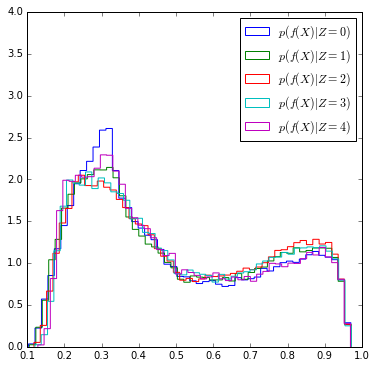

In [490]:
plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.hist(1. - D.predict(make_X(50000, z=3)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=3)$")
plt.hist(1. - D.predict(make_X(50000, z=4)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=4)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-adversary.pdf")
plt.show()

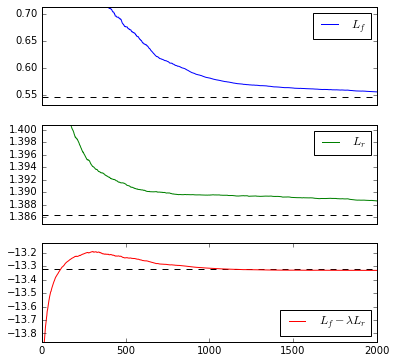

In [492]:
def plot_losses_final(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    n_iter = len(np.array(losses["L_f"]))-1

    ax1 = plt.subplot(311)  
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")   
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed")
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xticks([])
    plt.xlim(0, n_iter)
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.hlines(min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lr, values.min())
    high = max(min_Lr, values.max())
    high = high - (high-low) * 0.9
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.hlines(min_Lf - lam*min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lf - lam*min_Lr, values.min())
    high = max(min_Lf - lam*min_Lr, values.max())
    low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.legend(loc="lower right")
    
    #plt.savefig("training.pdf")
    
    plt.show()  
    
plot_losses_final(losses)

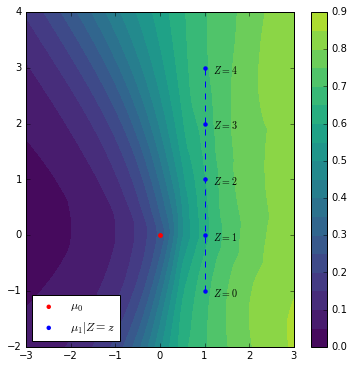

In [491]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 2.5
y_pred = D.predict(X_test).ravel()

from matplotlib.mlab import griddata
xi = np.linspace(-3., 3., 100)
yi = np.linspace(-2, 4, 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [-1], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0], c="blue", linewidths=0)
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [2], c="blue", linewidths=0)
plt.scatter([1], [3], c="blue", linewidths=0)
plt.scatter([0], [0], c="red", linewidths=0)
plt.vlines(1, -1, 3, color="blue", linestyles="dashed")
plt.text(1.2, -1-0.1, "$Z=0$", color="k")
plt.text(1.2, -1+1-0.1, "$Z=1$", color="k")
plt.text(1.2, -1+2-0.1, "$Z=2$", color="k")
plt.text(1.2, -1+3-0.1, "$Z=3$", color="k")
plt.text(1.2, 3-0.1, "$Z=4$", color="k")
plt.xlim(-3,3)
plt.ylim(-2,4)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-adversary.pdf")
plt.show()

In [175]:
#D.save_weights("D.weights")